# Example workflow 

This notebook provides a brief introduction to using F3DAS code.
In general, the whole framework consists of 3 steps:

1. Design of Experiments (DoE) - generating sample design points
2. Computational analyses  - simulating sample designs (FEM, Abaqus)
3. Machine learning - building response model over the design space



#### Steps 1 and 2 are implemented with STEP1_F3DAS.m code. 

To run the experiment, go to the code and  define folowing:
 1. DoE: size & bounds: starts at line 28
 2. Inputs: starts at line 60
 3. Imperfections: starts at line 87
 
- Aside from the values, define names of folders for your analysis
- After a succesfull run you should have 3 folders: 1_DoE, 2_Inputs, 3_Analyses; inside each folder there should be a folder named as defined previously. 


Step 3 - machine learning can be implemented using functions from ML_utils.py
Example is shown in this notebook. 
    


In [1]:
import numpy as np
import copy
import os
import tensorflow as tf
from SALib.sample import saltelli
from SALib.analyze import sobol
from timeit import default_timer as timer
from scipy import interpolate
from scipy import stats
import pandas as pd
import seaborn as sns
from scipy.integrate import simps, trapz
import h5py
from matplotlib.colors import LogNorm

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel, WhiteKernel)


# Matplotlib
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib
from matplotlib import rc
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib as mpl
from scipy import stats

# Preprocessing data:
from sklearn.preprocessing import StandardScaler
import gpflow 
import logging
logging.basicConfig(format='%(asctime)s %(message)s')

# Postprocessing metrics:
from sklearn.metrics import mean_squared_error, r2_score , explained_variance_score, classification_report
import GPy
from sklearn.preprocessing import StandardScaler
from scipy.interpolate import griddata
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pprint
from matplotlib.ticker import FuncFormatter

# To save the model:
from sklearn.externals import joblib
import os
import errno
import scipy.io as sio
try:
    import cPickle as pickle  # Improve speed
except ImportError:
    import pickle

# Take care of some general properties of the plots:
rc('text', usetex=True)
rc('font', family='serif',size=20)

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20#20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def move_sn_y(offs=0, dig=0, side='left', omit_last=False):
    """Move scientific notation exponent from top to the side.
    
    Additionally, one can set the number of digits after the comma
    for the y-ticks, hence if it should state 1, 1.0, 1.00 and so forth.

    Parameters
    ----------
    offs : float, optional; <0>
        Horizontal movement additional to default.
    dig : int, optional; <0>
        Number of decimals after the comma.
    side : string, optional; {<'left'>, 'right'}
        To choose the side of the y-axis notation.
    omit_last : bool, optional; <False>
        If True, the top y-axis-label is omitted.

    Returns
    -------
    locs : list
        List of y-tick locations.

    Note
    ----
    This is kind of a non-satisfying hack, which should be handled more
    properly. But it works. Functions to look at for a better implementation:
    ax.ticklabel_format
    ax.yaxis.major.formatter.set_offset_string
    """

    # Get the ticks
    locs, _ = plt.yticks()

    # Put the last entry into a string, ensuring it is in scientific notation
    # E.g: 123456789 => '1.235e+08'
    llocs = '%.3e' % locs[-1]

    # Get the magnitude, hence the number after the 'e'
    # E.g: '1.235e+08' => 8
    yoff = int(str(llocs).split('e')[1])

    # If omit_last, remove last entry
    if omit_last:
        slocs = locs[:-1]
    else:
        slocs = locs

    # Set ticks to the requested precision
    form = r'$%.'+str(dig)+'f$'
    plt.yticks(locs, list(map(lambda x: form % x, slocs/(10**yoff))))

    # Define offset depending on the side
    if side == 'left':
        offs = -.18 - offs # Default left: -0.18
    elif side == 'right':
        offs = 1 + offs    # Default right: 1.0
        
    # Plot the exponent
    plt.text(offs, .98, r'$\times10^{%i}$' % yoff, transform =
            plt.gca().transAxes, verticalalignment='top')

    return locs

class nf(float):
    def __repr__(self):
        str = '%.1f' % (self.__float__(),)
        if str[-1] == '0':
            return '%.1f' % self.__float__()
        else:
            return '%.1f' % self.__float__()
        
        
from ML_utils import *


First, you can load all the data using 'Dataset' class from Postproc_utils, as shown below. Iniitalizing the class loads all the iinputs from the folder. Calling 'postproc()' runs over the data and filters out failed simulations and assembles a 'Response' dictionary, which can be used to retrieve the outputs. 

In [2]:
cwd = os.getcwd()
dir_path = os.path.dirname(cwd + '/sample_data/Set-PD-Ix-100/') 
D1= Dataset(dir_path, analysis_name = 'DOE_Ix-PD-100')
D1.postproc()



You can access the data, e.g:

In [3]:
D1._DoE.keys()

dict_keys(['size', 'vars', 'LowerBounds', 'UpperBounds', 'points'])

In [4]:
D1._DoE['vars']

['$\\frac{A}{D_1^2}$',
 '$\\frac{G}{E}$',
 '$\\frac{Ix}{D_1^4}$',
 '$\\frac{Iy}{D_1^4}$',
 '$\\frac{J}{D_1^4}$',
 '$\\frac{P}{D_1}$',
 '$\\frac{D_1-D_2}{D_1}$',
 'Imperfection']

Can also check response of a single sample, e.g.:

In [5]:
cell_params = D1._DoE['points'][63]
data = D1._STRUCTURES_data['Input1']['Imperfection1']['DoE63']
diameter = D1._D1

mm_sample = Unit_cell(data, cell_params, diameter)

In [6]:
mm_sample._Response

{'max_strain': 0.999899989999,
 'max_stress': 30.184164551734064,
 'strain': array([0.00000000e+00, 1.00010001e-04, 2.00020002e-04, ...,
        9.99699970e-01, 9.99799980e-01, 9.99899990e-01]),
 'stress': array([0.00000000e+00, 7.61881506e-01, 1.51734782e+00, ...,
        1.28546346e-06, 5.71284967e-07, 1.42813210e-07]),
 'Eabs': 7.319151634435393,
 'Pcrit': 44.48189673486765,
 'coilable': 1.0}

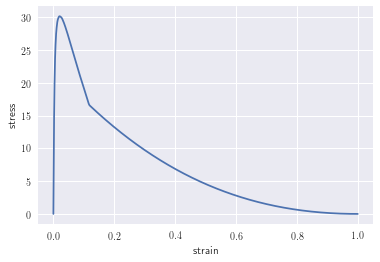

In [7]:
fig = mm_sample.plot_response()
plt.show()

Next, specify the training dataset. This can be done using 'TrainingDataset' class, which basically lads X and Y values, and rescales them using sklearn scaler. 

Inputs and response are stored as 3d lists, where 1st index is the 'Input', 2nd is the 'Imperfection' and 3rd is 'DoE'. Those numbers were specified in STEP1_F3DAS.m code. 

The sample data was obtained with only 1 iperfection and 1 Input, so I set those indices to 0. 


In [8]:
iInput = 0
kImperf = 0

Pcrit = D1._Response['Pcrit'][iInput][kImperf] #to check other choices: D1._Response.keys()
X = D1._X[iInput][kImperf]                     #to look up which variables are in whic columns: D1._DoE['vars']

t1 = TrainingDataset(X[:, [2] ], Pcrit)

Finally, I can specify a ML model. You can either do it on your own, using package of your choice (sklearn/GP/gpflow), or select a class from ML_utils.py

 /home/gawel/anaconda3/envs/MLenv/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/3, f = 194.32397495285088
Optimization restart 2/3, f = 194.3239749534765
Optimization restart 3/3, f = 194.32397496377934


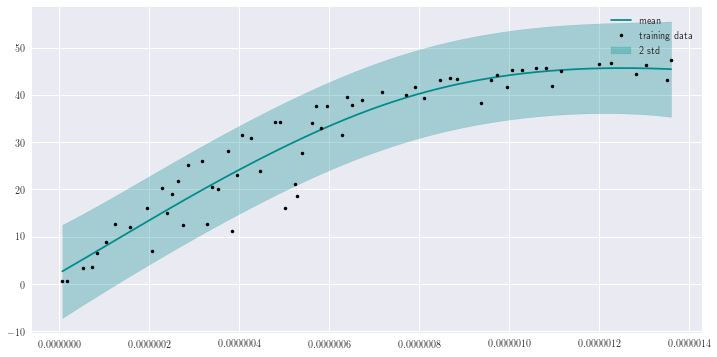

In [9]:
G2 = GPR_GPy(t1)
Xnew = np.linspace(np.min(X[:, [2] ]), np.max(X[:, [2] ]), 1000)

mu, cov = G2.predict(Xnew)
fig = plot_GP(mu, np.sqrt(cov), Xnew, t1)

You can select other model, and compare the results using the same data

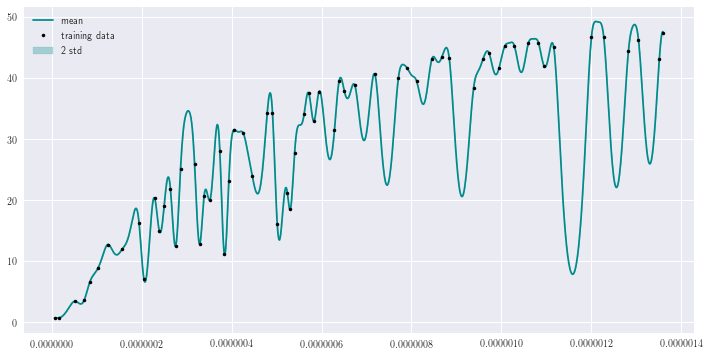

In [15]:
G1 = GPR_sklearn(t1)
mu, cov = G1.predict(Xnew)
fig = plot_GP(mu, cov, Xnew, t1)



This one is clearly overfitting. You can always access the model, and change its parameters. E.g.:

In [11]:
G1._model

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=Matern(length_scale=1, nu=2.5),
                         n_restarts_optimizer=10, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)

We can try to change kernel. 

In [46]:
G1._model.kernel = Matern(nu = 0.5, length_scale_bounds = (1e-3, 1e3)) + WhiteKernel(noise_level=.1, noise_level_bounds=(1e-10, 1e+1))

After you changed model, you need to train it again by calling .train()

In [50]:
G1.train()

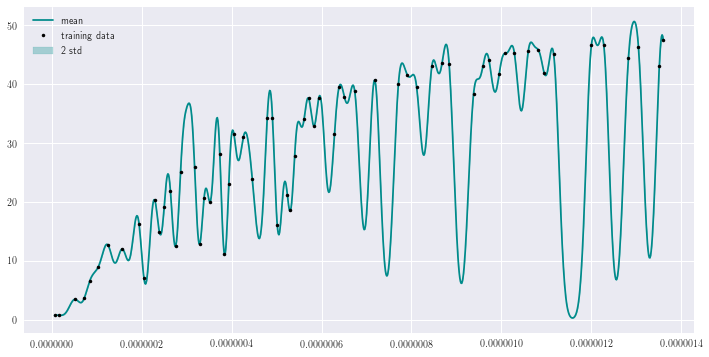

In [51]:
mu, cov = G1.predict(Xnew)
fig = plot_GP(mu, cov, Xnew, t1)

In [67]:
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
G1._model.kernel = C(1.0, (1e-3, 1e3))*RBF(10, (1e-2, 1e2)) + WhiteKernel(noise_level=.1, noise_level_bounds=(1e-3, 1e+1))

In [68]:
G1.train()

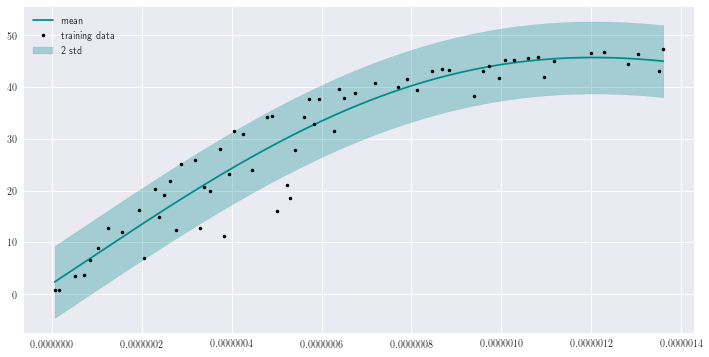

In [69]:
mu, cov = G1.predict(Xnew)
fig = plot_GP(mu, cov, Xnew, t1)